In [1]:
from utils import load_embedding, parse_tup, cos_sim, cos_dist
from tqdm.auto import tqdm
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd

In [2]:
# from utils import CANDIDATE_SUBS
TIME_FRAME = "monthly"
left_candidates = ["JoeBiden","SandersForPresident","BaemyKlobaechar","ElizabethWarren","Pete_Buttigieg","YangForPresidentHQ"]
right_candidates = ["The_Donald"]
mapping = {}
for a,b in zip(left_candidates+right_candidates,px.colors.qualitative.Plotly):
    mapping[a] = b

## Buisness Insider Polling Data

In [3]:
from glob import glob
cols = ["respondent_id","date","will_vote","political_beliefs","registered","ethnicity","age","gender","income","region"]
path = "/h/224/cameron/Political-Subreddit-Embedding/external_datasets/polling_data/buisness_insider"
gl = glob(f"{path}/*.csv")
li = [pd.read_csv(fn) for fn in gl]
cleaned = []
concat_col_names = ["supports_biden","supports_sanders","supports_klobuchar","supports_warren","supports_buttigieg","supports_yang"]
cands = ["Fmr. V.P. Joe Biden","Sen. Bernie Sanders","Sen. Amy Klobuchar","Sen. Elizabeth Warren","South Bend Mayor Pete Buttigieg","Andrew Yang"]
for df in tqdm(li):
    # Go through each data frame, concatenate all the columns that start with "Which of the following candidates would you be satisfied"
    # and then add columns for each of the candidates in our analyis, true if they land in one of those prior columns
    # (indicating support) or false otherwise
    would_support = [c for c in df.columns if c.startswith("Which of the following candidates would you be satisfied ")]
    for cand, col in zip(cands,concat_col_names):
        df[col] = df[would_support].apply(lambda x : 1 if cand in list(x) else 0,axis=1)
        
    def other_support(x):
        # if they support one of the candidates
        if x[concat_col_names].any():
            return 0,0
        # if they don't support any of our selected candidates but support some other candidate
        elif not x[concat_col_names].any() and x[would_support].any():
            return 1, 0
        # otherwise they must not support any candidate
        return 0,1
    df['supports_other'], df['no_support'] = zip(*df.apply(other_support,axis=1))
    df = df.rename({"Respondent ID": "respondent_id",
                    "Start Date": "date",
                    "Do you think you will participate in the 2020 presidential primary?": "will_vote",
                    "What best describes your political beliefs?": "political_beliefs",
                    "Are you a registered voter?": "registered",
                    "Which race/ethnicity best describes you? (Please choose only one.)": "ethnicity",
                    "Age": "age","Gender": "gender","Household Income": "income","Region": "region"
                   },axis=1)
    df = df[cols+concat_col_names+["supports_other","no_support"]]
    cleaned.append(df)

bi_poll = pd.concat(cleaned, axis=0, ignore_index=True)
bi_poll["date"] = pd.to_datetime(bi_poll["date"])
bi_poll = bi_poll.sort_values("date")
# Drop those who haven't made up their mind
bi_poll = bi_poll[bi_poll["no_support"] == 0]
bi_poll.head()

respondent_id                date  \
4548    10491448652 2019-01-26 13:36:57   
4545    10491448848 2019-01-26 13:37:03   
4547    10491448683 2019-01-26 13:37:04   
4533    10491449586 2019-01-26 13:37:18   
4546    10491448847 2019-01-26 13:37:19   

                                              will_vote  \
4548  Yes I will likely vote in my state's Democrati...   
4545  Yes I will likely vote in my state's Republica...   
4547  Yes I will likely vote in my state's Democrati...   
4533                 I don't know or I'd rather not say   
4546  Yes I will likely vote in my state's Democrati...   

                     political_beliefs registered           ethnicity    age  \
4548                Moderately liberal        Yes  Hispanic or Latino  45-60   
4545           Moderately conservative        Yes  White or Caucasian   > 60   
4547                  Slightly liberal        Yes  White or Caucasian  30-44   
4533  Neither liberal nor conservative        Yes  White or Caucasian  18-29   
4546                Moderately liberal        Yes  White or Caucasian  18-29   

      gender                income              region  supports_biden  \
4548  Female         $75000-$99999      South Atlantic               0   
4545  Female         $25000-$49999     Middle Atlantic               1   
4547  Female         $75000-$99999      South Atlantic               1   
4533  Female  Prefer not to answer  West North Central               1   
4546  Female         $25000-$49999      South Atlantic               1   

      supports_sanders  supports_klobuchar  supports_warren  \
4548                 0                   0                0   
4545                 1                   0                0   
4547                 0                   0                0   
4533                 0                   0                0   
4546                 0                   0                0   

      supports_buttigieg  supports_yang  supports_other  no_support  
4548                   0              0               1           0  
4545                   0              0               0           0  
4547                   0              0               0           0  
4533                   0              0               0           0  
4546                   0              0               0           0

In [4]:
polling_agg = bi_poll.groupby([pd.Grouper(key='date', freq='M')])[["supports_other"]+concat_col_names].sum().reset_index().sort_values('date')
# Convert to pct
polling_agg = polling_agg.set_index('date')
polling_agg = polling_agg.div(polling_agg.sum(axis=1), axis=0)
polling_agg = polling_agg.reset_index()
polling_agg

date  supports_other  supports_biden  supports_sanders  \
0  2019-01-31        0.298692        0.281487          0.240881   
1  2019-02-28        0.233148        0.314569          0.248611   
2  2019-03-31        0.197178        0.309700          0.247619   
3  2019-04-30        0.190602        0.284585          0.237154   
4  2019-05-31        0.171841        0.292756          0.219227   
5  2019-06-30        0.164988        0.275260          0.220544   
6  2019-07-31        0.161724        0.268725          0.210945   
7  2019-08-31        0.153079        0.248438          0.224338   
8  2019-09-30        0.141719        0.243002          0.208204   
9  2019-10-31        0.127326        0.228682          0.212016   
10 2019-11-30        0.139695        0.229848          0.205888   
11 2019-12-31        0.128488        0.216824          0.225657   
12 2020-01-31        0.118185        0.213592          0.221807   
13 2020-02-29        0.121443        0.194589          0.247094   
14 2020-03-31        0.112589        0.487589          0.399823   

    supports_klobuchar  supports_warren  supports_buttigieg  supports_yang  
0             0.041982         0.124570            0.012388       0.000000  
1             0.048079         0.137231            0.018362       0.000000  
2             0.052910         0.136861            0.039859       0.015873  
3             0.044137         0.124726            0.090031       0.028766  
4             0.043573         0.140795            0.093137       0.038671  
5             0.044478         0.157771            0.093152       0.043807  
6             0.041883         0.176399            0.092938       0.047386  
7             0.038828         0.176436            0.096549       0.062333  
8             0.047434         0.184098            0.094285       0.081260  
9             0.054070         0.188953            0.097093       0.091860  
10            0.055228         0.181117            0.100914       0.087310  
11            0.052801         0.172656            0.102791       0.100783  
12            0.069828         0.160007            0.102689       0.113891  
13            0.092184         0.163727            0.143287       0.037675  
14            0.000000         0.000000            0.000000       0.000000

In [5]:
pretty_names = ["Joseph R. Biden Jr.","Bernard Sanders","Amy Klobuchar","Elizabeth Warren","Pete Buttigieg","Andrew Yang"]
poll_mapping = {}
for a,b in zip(pretty_names,px.colors.qualitative.Plotly):
    poll_mapping[a] = b
    
fig = go.Figure()
for cand,col in zip(pretty_names,concat_col_names):
    fig.add_trace(go.Scatter(x=polling_agg["date"],
                             y=polling_agg[col], 
                             mode='lines',
                             line_shape="spline",
                             name=cand,
                             line=dict(color=poll_mapping[cand])
                            ))

    # Add figure title
fig.update_layout(
    title_text="Buisness Intelligence Polling - Candidate Favourability",
    template="simple_white",
    yaxis=dict(tickformat=',.0%',range=[0,0.6])
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Polling Average")

fig.write_html("visualizations/BI_polling_average-ALL.html")
fig.show()

### Only young voters

In [6]:
young_voters = bi_poll[bi_poll["age"] == "18-29"]
young_voters_agg = young_voters.groupby([pd.Grouper(key='date', freq='M')])[["supports_other"]+concat_col_names].sum().reset_index().sort_values('date')
# Convert to pct
young_voters_agg = young_voters_agg.set_index('date')
young_voters_agg = young_voters_agg.div(young_voters_agg.sum(axis=1), axis=0)
young_voters_agg = young_voters_agg.reset_index()
young_voters_agg

date  supports_other  supports_biden  supports_sanders  \
0  2019-01-31        0.314578        0.263427          0.312020   
1  2019-02-28        0.268317        0.270297          0.316832   
2  2019-03-31        0.209424        0.278796          0.303665   
3  2019-04-30        0.227197        0.239635          0.304312   
4  2019-05-31        0.215733        0.225268          0.280095   
5  2019-06-30        0.217018        0.230871          0.275066   
6  2019-07-31        0.198135        0.213287          0.277389   
7  2019-08-31        0.161031        0.190553          0.307032   
8  2019-09-30        0.178651        0.168273          0.272795   
9  2019-10-31        0.131519        0.183673          0.281935   
10 2019-11-30        0.134069        0.180599          0.274448   
11 2019-12-31        0.124525        0.188307          0.290053   
12 2020-01-31        0.110959        0.183562          0.292466   
13 2020-02-29        0.115352        0.162002          0.367260   
14 2020-03-31        0.087227        0.339564          0.573209   

    supports_klobuchar  supports_warren  supports_buttigieg  supports_yang  
0             0.020460         0.076726            0.012788       0.000000  
1             0.025743         0.108911            0.009901       0.000000  
2             0.032723         0.124346            0.022251       0.028796  
3             0.026534         0.104478            0.050580       0.047264  
4             0.023838         0.132300            0.061979       0.060787  
5             0.023747         0.131266            0.052111       0.069921  
6             0.020979         0.156177            0.066434       0.067599  
7             0.019324         0.165862            0.067633       0.088567  
8             0.026686         0.161601            0.059303       0.132691  
9             0.025699         0.179138            0.058957       0.139078  
10            0.020505         0.174290            0.067823       0.148265  
11            0.022779         0.168565            0.056188       0.149582  
12            0.032877         0.160959            0.067123       0.152055  
13            0.042409         0.184054            0.087362       0.041561  
14            0.000000         0.000000            0.000000       0.000000

In [7]:
fig = go.Figure()
for cand,col in zip(pretty_names,concat_col_names):
    fig.add_trace(go.Scatter(x=young_voters_agg["date"],
                             y=young_voters_agg[col], 
                             mode='lines',
                             line_shape="spline",
                             name=cand,
                             line=dict(color=poll_mapping[cand])
                            ))

    # Add figure title
fig.update_layout(
    title_text="Buisness Intelligence Polling - Candidate Favourability (18-29 Age Group)",
    template="simple_white",
    yaxis=dict(tickformat=',.0%',range=[0,0.6])

)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Polling Average")

# fig.write_html("visualizations/BI_polling_average-YOUNG.html")
fig.show()

### Poller Age Distribution

In [8]:
age_dist = bi_poll.groupby("age").size().reset_index()

fig = px.pie(age_dist, values=0, names='age', title='Buisness Intelligence Poll Age Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.write_html("visualizations/BI_polling_age_dist.html")
fig.show()

## Comments over time

In [3]:
subreddit_comments = pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/temp/temporal/{}_wv.txt".format(TIME_FRAME),header=None,sep=' ')
subreddit_comments[0], subreddit_comments["date"] = subreddit_comments[0].apply(lambda x: parse_tup(x,date_str="%d/%m/%Y")).str
subreddit_comments = subreddit_comments.rename({0:"subreddit",1:"count"},axis=1)
subreddit_comments = subreddit_comments[subreddit_comments["subreddit"].isin(left_candidates) | subreddit_comments["subreddit"].isin(right_candidates)].reset_index(drop=True)
idx = pd.MultiIndex.from_product([subreddit_comments['date'].unique(), subreddit_comments['subreddit'].unique()],
                                 names=['date', 'subreddit'])

# In the case that there isn't a vector for a specific date/subreddit we backfill the vector from the previous
subreddit_comments = subreddit_comments.set_index(['date', 'subreddit']).reindex(idx).reset_index().sort_values('date').fillna(1)
subreddit_comments

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


date            subreddit   count
19 2019-01-01  SandersForPresident   22016
20 2019-01-01      BaemyKlobaechar     101
18 2019-01-01           The_Donald  968642
17 2019-01-01      ElizabethWarren     454
16 2019-01-01   YangForPresidentHQ      95
..        ...                  ...     ...
61 2019-12-01  SandersForPresident   90414
60 2019-12-01           The_Donald  698631
59 2019-12-01      ElizabethWarren   11451
58 2019-12-01   YangForPresidentHQ  225756
57 2019-12-01       Pete_Buttigieg   73831

[84 rows x 3 columns]

In [8]:
args = {
    "x": "date",
    "y": "count",
    "color": "subreddit",
    "line_shape": "spline",
    "title":  "Comments Over Time",
    "template": "simple_white",
    "labels": {"count": "# Comments", "date": "Date", "subreddit": "Subreddit"},
    "color_discrete_map": mapping

}

fig = px.line(subreddit_comments,**args)
fig.update_layout(
    annotations=[
        dict(
            x="2019-02-24",
            y=np.log10(32000),
            ay=20,
            text="Yang AMA on /r/politics",
        ),
        dict(
            x="2019-06-18",
            y=np.log10(30000),
            ay=-55,
            text="Sanders AMA on /r/SandersForPresident",
        ),
        
        dict(
            x="2019-04-19",
            y=np.log10(30000),
            ay=40,
            text="Buttigieg announces campaign",
        ),
        dict(
            x="2019-01-23",
            y=np.log10(72),
            ay=20,
            ax=60,
            text="Buttigieg exploratory committee",
        ),
        dict(
            x="2019-02-10",
            y=np.log10(135),
            ay=-10,
            ax=100,
            text="Klobuchar announces campaign",
        ),
        dict(
            x="2019-02-19",
            y=np.log10(67000),
            ay=-20,
            text="Sanders announces campaign",
        ),
        dict(
            x="2019-02-09",
            y=np.log10(420),
            ay=-20,
            text="Warren announces campaign",
        ),
        
    ]
)

fig.update_yaxes(type="log")

fig.write_html("visualizations/temporal/{}_subreddit_counts.html".format(TIME_FRAME))
fig.show()

## Dual Axes

In [11]:
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add subreddit comments
for sub in left_candidates:
    data = subreddit_comments[subreddit_comments["subreddit"] == sub]
    fig.add_trace(
        go.Scatter(x=data["date"],
                   y=data["count"],
                   name="{} Subreddit Comments".format(sub),
                   line_shape="spline",
                   mode='lines',
                   line=dict(color=mapping[sub],dash='dash')),
        secondary_y=True)

# Add from media coverage
for cand,col in zip(pretty_names,concat_col_names):
    fig.add_trace(go.Scatter(x=young_voters_agg["date"],
                             y=young_voters_agg[col], 
                             mode='lines',
                             line_shape="spline",
                             name="{} Polling Avg".format(cand),
                             line=dict(color=poll_mapping[cand])
                            ),
                 secondary_y=False)



# Add figure title
fig.update_layout(
    title_text="Dual Axis - Subreddit Comments and Polling Average (18-29 Age Group)",
    template="simple_white",
    legend=dict(orientation='v', x=1.1, xanchor='left', y=1),
)

fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Polling</b> Average", secondary_y=False)
fig.update_yaxes(title_text="<b>Subreddit</b> Comments", secondary_y=True)
# fig.write_html("visualizations/temporal/{}_BI_counts_vs_polling_avg-YOUNG.html".format(TIME_FRAME))
fig.show()

## Pearson Correlation
Correlation between candidate polling and subreddit comments

In [12]:
t1 = polling_agg[["date","supports_biden","supports_sanders","supports_klobuchar","supports_warren","supports_buttigieg","supports_yang"]]
t1.columns = ["date","Joseph R. Biden","Bernard Sanders","Amy Klobuchar","Elizabeth Warren","Pete Buttigieg","Andrew Yang"]
t1 = pd.melt(t1, 
            id_vars='date', 
            value_vars=list(t1.columns)[1:], # list of days of the week
            var_name='candidate',
            value_name='polling_avg')
t1["date"] = t1["date"].dt.to_period('M')

t2 = subreddit_comments[subreddit_comments["subreddit"] != "The_Donald"].copy()
t2["date"] = t2["date"].dt.to_period('M')
m = {
    "SandersForPresident": "Bernard Sanders",
    "BaemyKlobaechar": "Amy Klobuchar",
    "JoeBiden": "Joseph R. Biden",
    "ElizabethWarren": "Elizabeth Warren",
    "Pete_Buttigieg": "Pete Buttigieg",
    "YangForPresidentHQ": "Andrew Yang"
}
t2["subreddit"] = t2["subreddit"].apply(lambda x : m[x])
polling_comments_df = pd.merge(t1, t2,  how='inner', left_on=['date','candidate'], right_on = ['date','subreddit']).sort_values(["date","candidate"])
polling_comments_df = polling_comments_df.drop("subreddit",axis=1)
polling_comments_df

date         candidate  polling_avg   count
24  2019-01     Amy Klobuchar     0.041982     101
60  2019-01       Andrew Yang     0.000000      95
12  2019-01   Bernard Sanders     0.240881   22016
36  2019-01  Elizabeth Warren     0.124570     454
0   2019-01   Joseph R. Biden     0.281487       1
..      ...               ...          ...     ...
71  2019-12       Andrew Yang     0.100783  225756
23  2019-12   Bernard Sanders     0.225657   90414
47  2019-12  Elizabeth Warren     0.172656   11451
11  2019-12   Joseph R. Biden     0.216824    3825
59  2019-12    Pete Buttigieg     0.102791   73831

[72 rows x 4 columns]

### Only Young Voters

In [13]:
t1 = young_voters_agg[["date","supports_biden","supports_sanders","supports_klobuchar","supports_warren","supports_buttigieg","supports_yang"]]
t1.columns = ["date","Joseph R. Biden","Bernard Sanders","Amy Klobuchar","Elizabeth Warren","Pete Buttigieg","Andrew Yang"]
t1 = pd.melt(t1, 
            id_vars='date', 
            value_vars=list(t1.columns)[1:], # candidates
            var_name='candidate',
            value_name='polling_avg')
t1["date"] = t1["date"].dt.to_period('M')

t2 = subreddit_comments[subreddit_comments["subreddit"] != "The_Donald"].copy()
t2["date"] = t2["date"].dt.to_period('M')
m = {
    "SandersForPresident": "Bernard Sanders",
    "BaemyKlobaechar": "Amy Klobuchar",
    "JoeBiden": "Joseph R. Biden",
    "ElizabethWarren": "Elizabeth Warren",
    "Pete_Buttigieg": "Pete Buttigieg",
    "YangForPresidentHQ": "Andrew Yang"
}
t2["subreddit"] = t2["subreddit"].apply(lambda x : m[x])
polling_comments_df_young = pd.merge(t1, t2,  how='inner', left_on=['date','candidate'], right_on = ['date','subreddit']).sort_values(["date","candidate"])
polling_comments_df_young = polling_comments_df_young.drop("subreddit",axis=1)
polling_comments_df_young.head()

date         candidate  polling_avg  count
24  2019-01     Amy Klobuchar     0.020460    101
60  2019-01       Andrew Yang     0.000000     95
12  2019-01   Bernard Sanders     0.312020  22016
36  2019-01  Elizabeth Warren     0.076726    454
0   2019-01   Joseph R. Biden     0.263427      1

### Visualize

In [14]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Overall Populous",
                    "18-29 Age Group"))

c_mapping = {}
cands = ["Joseph R. Biden","Bernard Sanders","Amy Klobuchar","Elizabeth Warren","Pete Buttigieg","Andrew Yang"]
for a,b in zip(cands,px.colors.qualitative.Plotly):
    c_mapping[a] = b

for cand in cands:
    pop_df = polling_comments_df[polling_comments_df["candidate"] == cand]
    young_df = polling_comments_df_young[polling_comments_df_young["candidate"] == cand]
    
    fig.add_trace(go.Scatter(x=pop_df["polling_avg"],
                             y=pop_df["count"],
                             marker=dict(color=c_mapping[cand]),                         
                             mode="markers",
                             name=cand,
                             legendgroup=cand
                            ),
                  row=1,
                  col=1)


    fig.add_trace(go.Scatter(x=young_df["polling_avg"],
                             y=young_df["count"],
                             marker=dict(color=c_mapping[cand]),
                             mode="markers",
                             name=cand,
                             legendgroup=cand,
                            showlegend = False
                            ),
                  row=1,
                  col=2)

fig.update_layout(title_text="Subreddit Comments as a Function of Polling Data",
                  template="simple_white")
fig.update_xaxes(dict(tickformat=',.0%'))
fig.write_html("visualizations/temporal/{}_comments_over_polling_data_scatter.html".format(TIME_FRAME))
fig.show()

In [26]:
from scipy import stats
rho, pval = stats.pearsonr(polling_comments_df["polling_avg"],polling_comments_df["count"])
rank_c = {"name": ["Overall Correlation"],
          "rho": [rho],
          "pval": [pval]}

print("Overall correlation")
print(rho, pval)

rho, pval = stats.pearsonr(polling_comments_df_young["polling_avg"],polling_comments_df_young["count"])
rank_c_young = {"name": ["Overall Correlation"],
          "rho": [rho],
          "pval": [pval]}

print("Young Voter correlation")
print(rho, pval)

for cand in polling_comments_df["candidate"].unique():
    cand_info = polling_comments_df[polling_comments_df["candidate"] == cand]
    print(cand)
    r, p = stats.pearsonr(cand_info["polling_avg"],cand_info["count"])
    print("\t* {:.4f},{:.2e}".format(r, p))
    rank_c["name"].append(cand)
    rank_c["rho"].append(r)
    rank_c["pval"].append(p)
    
    cand_info = polling_comments_df_young[polling_comments_df_young["candidate"] == cand]
    r, p = stats.pearsonr(cand_info["polling_avg"],cand_info["count"])
    rank_c_young["name"].append(cand)
    rank_c_young["rho"].append(r)
    rank_c_young["pval"].append(p)
    print("\t* Young Voters: {:.4f},{:.2e}".format(r, p))

Overall correlation
-0.05220787921572048 0.6631685806246381
Young Voter correlation
0.21957300621274456 0.06385125444890084
Amy Klobuchar
	* 0.3294,2.96e-01
	* Young Voters: -0.0784,8.09e-01
Andrew Yang
	* 0.9414,4.92e-06
	* Young Voters: 0.9247,1.68e-05
Bernard Sanders
	* -0.3675,2.40e-01
	* Young Voters: -0.2866,3.66e-01
Elizabeth Warren
	* 0.9114,3.71e-05
	* Young Voters: 0.8732,2.08e-04
Joseph R. Biden
	* -0.7848,2.50e-03
	* Young Voters: -0.7593,4.18e-03
Pete Buttigieg
	* 0.7537,4.64e-03
	* Young Voters: 0.6482,2.26e-02


In [27]:
fig = go.Figure(data=[go.Bar(name='Overall Populous', x=rank_c["name"], y=rank_c["rho"],text=rank_c["pval"]),
                      go.Bar(name='18-29 Age Group', x=rank_c_young["name"], y=rank_c_young["rho"],text=rank_c_young["pval"])],
                layout={'yaxis': {'range': [-1,1.1]}})
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_traces(texttemplate='p=%{text:.2e}', textposition='outside')
# Add figure title
fig.update_layout(
    title_text="Pearson Correlation: Polling Average and Subreddit Comments",
    template="simple_white",
    legend=dict(orientation='v', x=1.1, xanchor='left', y=1),
)
fig.write_html("visualizations/temporal/pearson_correlation-polling_avg_comments.html".format(TIME_FRAME))
fig.show()

## Unique Commenters Over Time

In [10]:
import findspark
findspark.init("/h/224/cameron/spark-3.0.0-preview2-bin-hadoop2.7")
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, IntegerType,StringType

schema = StructType([
    StructField("subreddit", StringType(), True),
    StructField("username", StringType(), True),
    StructField("count", IntegerType(), True)])

spark = SparkSession.builder.getOrCreate()
spark.sparkContext.getConf().getAll()

s_user_comments = spark.read.format("csv").option("sep", " ").option("header", False).load("temp/temporal/monthly_data",schema=schema)
s_user_comments = s_user_comments.where(s_user_comments['subreddit'].rlike("|".join(["(" + cand + ")" for cand in left_candidates])))
s_user_comments.show()

+--------------------+--------------------+-----+
|           subreddit|            username|count|
+--------------------+--------------------+-----+
|(SandersForPresid...|        Japsenpapsen|   43|
|(YangForPresident...|          JonWood007|  325|
|(SandersForPresid...|        vegasaquinas|   17|
|(SandersForPresid...|            Andy1816|  138|
|(SandersForPresid...|      SharonLougheed|    5|
|(SandersForPresid...|             sethu85|    3|
|(YangForPresident...|     the_lamplighter|    3|
|(SandersForPresid...|SnapesGrayUnderpants|    5|
|(SandersForPresid...|          lapacheco7|   13|
|(SandersForPresid...|            Anbaheni|    3|
|(SandersForPresid...|            Herollit|    2|
|(YangForPresident...|         javaknight1|   12|
|(SandersForPresid...|           h2o_demon|    1|
|(SandersForPresid...|  StoleAGoodUsername|    1|
|(SandersForPresid...|           BloosCorn|    2|
|(SandersForPresid...|        carminedg123|   76|
|(SandersForPresid...|           sodafishy|    6|


In [21]:
user_comments = s_user_comments.toPandas()
user_comments['subreddit'], user_comments['date'] = zip(*user_comments['subreddit'].apply(lambda x: parse_tup(x,date_str="%d/%m/%Y")))
n_unique = user_comments.groupby(["subreddit","date"])['username'].nunique().reset_index().sort_values(["date","subreddit"]).reset_index(drop=True)
n_unique = n_unique.rename({"username": 'n_unique'},axis=1)
n_unique

subreddit       date  n_unique
0       BaemyKlobaechar 2019-01-01        37
1       ElizabethWarren 2019-01-01       120
2              JoeBiden 2019-01-01         1
3        Pete_Buttigieg 2019-01-01         8
4   SandersForPresident 2019-01-01      5508
..                  ...        ...       ...
67      ElizabethWarren 2019-12-01      1668
68             JoeBiden 2019-12-01       416
69       Pete_Buttigieg 2019-12-01      3520
70  SandersForPresident 2019-12-01     18982
71   YangForPresidentHQ 2019-12-01     17411

[72 rows x 3 columns]

In [22]:
args = {
    "x": "date",
    "y": "n_unique",
    "color": "subreddit",
    "line_shape": "spline",
    "title":  "Unique Commenters Over Time",
    "template": "simple_white",
    "labels": {"n_unique": "Unique Commenters", "date": "Month", "subreddit": "Subreddit"},
    "color_discrete_map": mapping
}

fig = px.line(n_unique,**args)
fig.update_layout(
    annotations=[
        dict(
            x="2019-02-24",
            y=np.log10(3500),
            text="Yang AMA on /r/politics",
        )
    ]
)
fig.update_yaxes(type="log")

fig.write_html("visualizations/temporal/{}_subreddit_n-unique.html".format(TIME_FRAME))
fig.show()

### Dual Axes (N-Unique)

In [23]:
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add subreddit comments
for sub in left_candidates:
    data = n_unique[n_unique["subreddit"] == sub]
    fig.add_trace(
        go.Scatter(x=data["date"],
                   y=data["n_unique"],
                   name="{} Subreddit Unique Commenters".format(sub),
                   mode='lines',
                   line=dict(color=mapping[sub],dash='dash')),
        secondary_y=True)

# Add from media coverage
for cand,col in zip(pretty_names,concat_col_names):
    fig.add_trace(go.Scatter(x=young_voters_agg["date"],
                             y=young_voters_agg[col], 
                             mode='lines',
                             line_shape="spline",
                             name="{} Polling Avg".format(cand),
                             line=dict(color=poll_mapping[cand])
                            ),
                 secondary_y=False)



# Add figure title
fig.update_layout(
    title_text="Dual Axis - Unique Commenters and Polling Average",
    template="simple_white",
    legend=dict(orientation='v', x=1.1, xanchor='left', y=1),
)

fig.update_xaxes(title_text="Time")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Polling</b> Average", secondary_y=False)
fig.update_yaxes(title_text="<b>Unique</b> Commenters", secondary_y=True)
fig.write_html("visualizations/temporal/{}_n-unique_vs_polling_avg.html".format(TIME_FRAME))
fig.show()

## Correlation 

In [24]:
n_unique["date"] = n_unique["date"].dt.to_period('M')
m = {
    "SandersForPresident": "Bernard Sanders",
    "BaemyKlobaechar": "Amy Klobuchar",
    "JoeBiden": "Joseph R. Biden",
    "ElizabethWarren": "Elizabeth Warren",
    "Pete_Buttigieg": "Pete Buttigieg",
    "YangForPresidentHQ": "Andrew Yang"
}
n_unique["subreddit"] = n_unique["subreddit"].apply(lambda x : m[x])
polling_commenters = pd.merge(polling_comments_df, n_unique,  how='inner', left_on=['date','candidate'], right_on = ['date','subreddit']).sort_values(["date","candidate"])
polling_commenters = polling_commenters[["date","candidate","polling_avg","n_unique"]]
polling_commenters

polling_commenters_young = pd.merge(polling_comments_df_young, n_unique,  how='inner', left_on=['date','candidate'], right_on = ['date','subreddit']).sort_values(["date","candidate"])
polling_commenters_young = polling_commenters_young[["date","candidate","polling_avg","n_unique"]]
polling_commenters_young.head()

date         candidate  polling_avg  n_unique
0  2019-01     Amy Klobuchar     0.020460        37
1  2019-01       Andrew Yang     0.000000        35
2  2019-01   Bernard Sanders     0.312020      5508
3  2019-01  Elizabeth Warren     0.076726       120
4  2019-01   Joseph R. Biden     0.263427         1

In [25]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Overall Populous",
                    "18-29 Age Group"))

c_mapping = {}
cands = ["Joseph R. Biden","Bernard Sanders","Amy Klobuchar","Elizabeth Warren","Pete Buttigieg","Andrew Yang"]
for a,b in zip(cands,px.colors.qualitative.Plotly):
    c_mapping[a] = b

for cand in cands:
    pop_df = polling_commenters[polling_commenters["candidate"] == cand]
    young_df = polling_commenters_young[polling_commenters_young["candidate"] == cand]
    
    fig.add_trace(go.Scatter(x=pop_df["polling_avg"],
                             y=pop_df["n_unique"],
                             marker=dict(color=c_mapping[cand]),                         
                             mode="markers",
                             name=cand,
                             legendgroup=cand
                            ),
                  row=1,
                  col=1)


    fig.add_trace(go.Scatter(x=young_df["polling_avg"],
                             y=young_df["n_unique"],
                             marker=dict(color=c_mapping[cand]),
                             mode="markers",
                             name=cand,
                             legendgroup=cand,
                            showlegend = False
                            ),
                  row=1,
                  col=2)

fig.update_layout(title_text="Unique Commenters as a Function of Polling Data",
                  template="simple_white")
fig.update_xaxes(dict(tickformat=',.0%'))
fig.write_html("visualizations/temporal/{}_n-unique_over_polling_data_scatter.html".format(TIME_FRAME))
fig.show()

In [28]:
rho, pval = stats.pearsonr(polling_commenters["polling_avg"],polling_commenters["n_unique"])
rank_c = {"name": ["Overall Correlation"],
          "rho": [rho],
          "pval": [pval]}

print("Overall correlation")
print(rho, pval)

rho, pval = stats.pearsonr(polling_commenters_young["polling_avg"],polling_commenters_young["n_unique"])
rank_c_young = {"name": ["Overall Correlation"],
          "rho": [rho],
          "pval": [pval]}

print("Young Voter correlation")
print(rho, pval)

for cand in polling_commenters["candidate"].unique():
    cand_info = polling_commenters[polling_commenters["candidate"] == cand]
    print(cand)
    r, p = stats.pearsonr(cand_info["polling_avg"],cand_info["n_unique"])
    print("\t* {:.4f},{:.4f}".format(r, p))
    rank_c["name"].append(cand)
    rank_c["rho"].append(r)
    rank_c["pval"].append(p)
    
    cand_info = polling_commenters_young[polling_commenters_young["candidate"] == cand]
    r, p = stats.pearsonr(cand_info["polling_avg"],cand_info["n_unique"])
    rank_c_young["name"].append(cand)
    rank_c_young["rho"].append(r)
    rank_c_young["pval"].append(p)
    print("\t* Young Voters: {:.4f},{:.4f}".format(r, p))

Overall correlation
0.18071373865655566 0.12873547518179423
Young Voter correlation
0.506442655231631 5.654968979089787e-06
Amy Klobuchar
	* 0.3309,0.2934
	* Young Voters: -0.0134,0.9670
Andrew Yang
	* 0.9631,0.0000
	* Young Voters: 0.9469,0.0000
Bernard Sanders
	* -0.3513,0.2628
	* Young Voters: -0.2726,0.3914
Elizabeth Warren
	* 0.9435,0.0000
	* Young Voters: 0.9066,0.0000
Joseph R. Biden
	* -0.7825,0.0026
	* Young Voters: -0.8624,0.0003
Pete Buttigieg
	* 0.8395,0.0006
	* Young Voters: 0.7481,0.0051


In [29]:
fig = go.Figure(data=[go.Bar(name='Overall Populous', x=rank_c["name"], y=rank_c["rho"],text=rank_c["pval"]),
                      go.Bar(name='18-29 Age Group', x=rank_c_young["name"], y=rank_c_young["rho"],text=rank_c_young["pval"])],
                layout={'yaxis': {'range': [-1,1.1]}})
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_traces(texttemplate='p=%{text:.2e}', textposition='outside')
# Add figure title
fig.update_layout(
    title_text="Pearson Correlation: Polling Average and Unique Commenters",
    template="simple_white",
    legend=dict(orientation='v', x=1.1, xanchor='left', y=1),
)
fig.write_html("visualizations/temporal/pearson_correlation-polling_avg_n_unique.html".format(TIME_FRAME))
fig.show()

## Comment Flows

In [7]:
user_comments = s_user_comments.toPandas()
user_comments['subreddit'], user_comments['date'] = zip(*user_comments['subreddit'].apply(lambda x: parse_tup(x,date_str="%d/%m/%Y")))
user_comments = user_comments.sort_values(['date','subreddit'])

user_comments

subreddit              username  count       date
537        BaemyKlobaechar         episcopaladin      3 2019-01-01
558        BaemyKlobaechar        aptlynameduser      7 2019-01-01
585        BaemyKlobaechar  pm_me_your_aloo_gobi      2 2019-01-01
591        BaemyKlobaechar          ErniePanders     11 2019-01-01
6911       BaemyKlobaechar             Brysynner      3 2019-01-01
...                    ...                   ...    ...        ...
298493  YangForPresidentHQ           vademecum19      1 2019-12-01
298495  YangForPresidentHQ               ToadBup      2 2019-12-01
298500  YangForPresidentHQ             RappyBird      1 2019-12-01
298502  YangForPresidentHQ          Curi0usj0r9e      1 2019-12-01
298538  YangForPresidentHQ        dangoatemybaby      1 2019-12-01

[301497 rows x 4 columns]

In [6]:
uc_pivot = pd.pivot_table(user_comments, values='count', index=['date','username'], columns=['subreddit']).fillna(0)
uc_pivot["max_sub"] = uc_pivot.idxmax(axis=1)
uc_pivot["count"] = uc_pivot.max(axis=1)
uc_pivot = uc_pivot[["max_sub","count"]].reset_index()
uc_pivot.head()

subreddit       date           username              max_sub  count
0         2019-01-01       --atreides--  SandersForPresident    1.0
1         2019-01-01          -Ashaman-  SandersForPresident    1.0
2         2019-01-01  -DementedAvenger-  SandersForPresident    1.0
3         2019-01-01   -Master-Builder-  SandersForPresident    4.0
4         2019-01-01      -Mediocrates-  SandersForPresident    2.0

In [96]:
flow = pd.pivot_table(uc_pivot,index='username',columns='date',values='max_sub',aggfunc=np.sum).reset_index().fillna("No_Comment")
flow = flow.drop("username",axis=1)
flow.head()

date 2019-01-01 00:00:00 2019-02-01 00:00:00  2019-03-01 00:00:00  \
0             No_Comment          No_Comment           No_Comment   
1             No_Comment          No_Comment  SandersForPresident   
2             No_Comment          No_Comment           No_Comment   
3             No_Comment          No_Comment   YangForPresidentHQ   
4             No_Comment          No_Comment           No_Comment   

date 2019-04-01 00:00:00 2019-05-01 00:00:00  2019-06-01 00:00:00  \
0             No_Comment          No_Comment  SandersForPresident   
1             No_Comment          No_Comment  SandersForPresident   
2             No_Comment          No_Comment           No_Comment   
3             No_Comment          No_Comment   YangForPresidentHQ   
4             No_Comment          No_Comment           No_Comment   

date  2019-07-01 00:00:00 2019-08-01 00:00:00 2019-09-01 00:00:00  \
0              No_Comment          No_Comment          No_Comment   
1      YangForPresidentHQ          No_Comment          No_Comment   
2              No_Comment          No_Comment          No_Comment   
3      YangForPresidentHQ  YangForPresidentHQ  YangForPresidentHQ   
4     SandersForPresident          No_Comment          No_Comment   

date 2019-10-01 00:00:00 2019-11-01 00:00:00  2019-12-01 00:00:00  
0             No_Comment          No_Comment           No_Comment  
1             No_Comment          No_Comment           No_Comment  
2             No_Comment          No_Comment  SandersForPresident  
3             No_Comment          No_Comment   YangForPresidentHQ  
4             No_Comment          No_Comment           No_Comment

In [97]:
# Count identical journeys (which is why you group by every column)
flow = flow.groupby(list(flow.columns)).size().to_frame().rename({0: 'count'},axis=1).reset_index()
flow.head()

2019-01-01 00:00:00 2019-02-01 00:00:00 2019-03-01 00:00:00  \
0     BaemyKlobaechar     BaemyKlobaechar     BaemyKlobaechar   
1     BaemyKlobaechar     BaemyKlobaechar     BaemyKlobaechar   
2     BaemyKlobaechar     BaemyKlobaechar          No_Comment   
3     BaemyKlobaechar     BaemyKlobaechar          No_Comment   
4     BaemyKlobaechar     BaemyKlobaechar          No_Comment   

  2019-04-01 00:00:00 2019-05-01 00:00:00 2019-06-01 00:00:00  \
0     BaemyKlobaechar     BaemyKlobaechar     BaemyKlobaechar   
1          No_Comment          No_Comment          No_Comment   
2     BaemyKlobaechar          No_Comment     BaemyKlobaechar   
3     BaemyKlobaechar      Pete_Buttigieg          No_Comment   
4            JoeBiden          No_Comment          No_Comment   

  2019-07-01 00:00:00 2019-08-01 00:00:00  2019-09-01 00:00:00  \
0     BaemyKlobaechar     BaemyKlobaechar      BaemyKlobaechar   
1          No_Comment          No_Comment           No_Comment   
2          No_Comment     BaemyKlobaechar      BaemyKlobaechar   
3          No_Comment          No_Comment  SandersForPresident   
4          No_Comment          No_Comment             JoeBiden   

  2019-10-01 00:00:00 2019-11-01 00:00:00 2019-12-01 00:00:00  count  
0     BaemyKlobaechar          No_Comment          No_Comment      1  
1          No_Comment          No_Comment     BaemyKlobaechar      1  
2          No_Comment          No_Comment          No_Comment      1  
3          No_Comment          No_Comment          No_Comment      1  
4          No_Comment      Pete_Buttigieg      Pete_Buttigieg      1

In [98]:
for i, col in enumerate(flow.columns[:-1]):
    flow[col] = flow[col].apply(lambda x : "{}: {}".format(i+1,x))
flow.head()

2019-01-01 00:00:00 2019-02-01 00:00:00 2019-03-01 00:00:00  \
0  1: BaemyKlobaechar  2: BaemyKlobaechar  3: BaemyKlobaechar   
1  1: BaemyKlobaechar  2: BaemyKlobaechar  3: BaemyKlobaechar   
2  1: BaemyKlobaechar  2: BaemyKlobaechar       3: No_Comment   
3  1: BaemyKlobaechar  2: BaemyKlobaechar       3: No_Comment   
4  1: BaemyKlobaechar  2: BaemyKlobaechar       3: No_Comment   

  2019-04-01 00:00:00 2019-05-01 00:00:00 2019-06-01 00:00:00  \
0  4: BaemyKlobaechar  5: BaemyKlobaechar  6: BaemyKlobaechar   
1       4: No_Comment       5: No_Comment       6: No_Comment   
2  4: BaemyKlobaechar       5: No_Comment  6: BaemyKlobaechar   
3  4: BaemyKlobaechar   5: Pete_Buttigieg       6: No_Comment   
4         4: JoeBiden       5: No_Comment       6: No_Comment   

  2019-07-01 00:00:00 2019-08-01 00:00:00     2019-09-01 00:00:00  \
0  7: BaemyKlobaechar  8: BaemyKlobaechar      9: BaemyKlobaechar   
1       7: No_Comment       8: No_Comment           9: No_Comment   
2       7: No_Comment  8: BaemyKlobaechar      9: BaemyKlobaechar   
3       7: No_Comment       8: No_Comment  9: SandersForPresident   
4       7: No_Comment       8: No_Comment             9: JoeBiden   

   2019-10-01 00:00:00 2019-11-01 00:00:00  2019-12-01 00:00:00  count  
0  10: BaemyKlobaechar      11: No_Comment       12: No_Comment      1  
1       10: No_Comment      11: No_Comment  12: BaemyKlobaechar      1  
2       10: No_Comment      11: No_Comment       12: No_Comment      1  
3       10: No_Comment      11: No_Comment       12: No_Comment      1  
4       10: No_Comment  11: Pete_Buttigieg   12: Pete_Buttigieg      1

In [108]:
# transform df into a source-target pair
f_cols = list(flow.columns)

label_list = ["{}: {}".format(i+1,cand) for i in range(12) for cand in left_candidates+["No_Comment"]]
color_list = [px.colors.qualitative.T10[c] for i in range(12) for c in range(len(left_candidates+["No_Comment"]))]
source_target_df =  pd.DataFrame(columns=['source','target','count'])
for i in range(len(f_cols)-2):
    temp_df = flow[[f_cols[i],f_cols[i+1],'count']]
    temp_df.columns = ['source','target','count']
    source_target_df = pd.concat([source_target_df,temp_df])
    source_target_df = source_target_df.groupby(['source','target']).agg({'count':'sum'}).reset_index()

# add index for source-target pair
source_target_df['sourceID'] = source_target_df['source'].apply(lambda x: label_list.index(x))
source_target_df['targetID'] = source_target_df['target'].apply(lambda x: label_list.index(x))
source_target_df = source_target_df[source_target_df["count"] > 70]
source_target_df["count"] = source_target_df["count"].apply(lambda x: np.log10(x)) 
source_target_df = source_target_df.sort_values(["sourceID","targetID"])
def color(row):
    s,t  = row["source"], row["target"]
    # Get the name after the colon
    s,t = s.split(":",1)[1].strip(),t.split(":",1)[1].strip()
    if t == "No_Comment":
        return "rgba(192,192,192,0.4)"
    return "rgba(0,0,160,0.4)" if s==t else "rgba(44, 160, 44,0.4)"
source_target_df["color"] = source_target_df[["source","target"]].apply(color,axis=1)
source_target_df.head()

source                  target     count  sourceID  \
109  1: SandersForPresident  2: SandersForPresident  3.321184         1   
108  1: SandersForPresident           2: No_Comment  3.528917         1   
103           1: No_Comment  2: SandersForPresident  3.975432         6   
98            1: No_Comment      2: BaemyKlobaechar  1.857332         6   
99            1: No_Comment      2: ElizabethWarren  1.919078         6   

     targetID                  color  
109         8      rgba(0,0,160,0.4)  
108        13  rgba(192,192,192,0.4)  
103         8  rgba(44, 160, 44,0.4)  
98          9  rgba(44, 160, 44,0.4)  
99         10  rgba(44, 160, 44,0.4)

In [122]:
data = [go.Sankey(
            node = dict(
              pad = 20,
              thickness = 10,
              line = dict(color = "black", width = 0.5),
              label = label_list,
              color = color_list,
              hovertemplate='10^%{value} users predominantly commented on %{label}<extra></extra>',  
            ),
            link = dict(
                source = source_target_df['sourceID'],
                target = source_target_df['targetID'],
                value = source_target_df['count'],
                hovertemplate='10^%{value} users switched subreddits<extra></extra>',
                color =  source_target_df['color']
            )
        )]

dates = [str(date)[:10] for date in uc_pivot["date"].unique()]
percs = [(i+i*0.1)/len(dates)for i in range(len(dates))]
annotations = [dict(x=perc,y=-0.1,text=str(date)[:10],showarrow=False) for perc,date in zip(percs,dates)]
annotations.append(dict(x=0.273,y=0.755,text="Users who predominantly comment on this subreddit",showarrow=True))
annotations.append(dict(x=0.052,y=0.53,text="Non-active users that month",showarrow=True))
# annotations.append(dict(x=0.05,y=0.23,text="Users switch main subreddit",showarrow=True))


layout = dict(
        height=600,
        width=3000,
        margin=dict(t=40, l=50, r=100, b=100),
        title="User Flow on Political Subreddits",
        font=dict(size=15),
        annotations=annotations
    )

fig = go.Figure(data=data,layout=layout)
fig.write_html("visualizations/temporal/{}_subreddit_flow.html".format(TIME_FRAME))
fig.show()

## Static Vector Similarity

In [11]:
embedding  = load_embedding("/h/224/cameron/Political-Subreddit-Embedding/trained_embeddings/vecs_0.0028_15.0.txt",split=False)
# filt = subreddits.isin(left_candidates) | subreddits.isin(right_candidates)
# subreddits, vectors = subreddits[filt], vectors[filt]
embedding = embedding[embedding.index.isin(left_candidates+right_candidates)]
embedding

1         2         3         4         5    \
subreddit                                                               
The_Donald           0.120521  0.030906 -0.108399  0.057453 -0.112398   
YangForPresidentHQ  -0.025037  0.058026 -0.145548 -0.120893 -0.177406   
SandersForPresident -0.000875  0.085712 -0.028338  0.075986  0.014858   
Pete_Buttigieg      -0.131488 -0.053883 -0.144259  0.005328 -0.132413   
ElizabethWarren     -0.014284  0.033747 -0.206298 -0.086125 -0.117959   
JoeBiden            -0.065129  0.055305 -0.111810 -0.046461 -0.014826   
BaemyKlobaechar     -0.104898 -0.001134 -0.118011  0.015278 -0.060789   

                          6         7         8         9         10   ...  \
subreddit                                                              ...   
The_Donald           0.023647  0.137943  0.055547 -0.155433  0.017703  ...   
YangForPresidentHQ   0.084242  0.044080  0.032779 -0.031671  0.007964  ...   
SandersForPresident -0.097731  0.132871  0.053717 -0.093353  0.044814  ...   
Pete_Buttigieg      -0.058815  0.103805  0.083708 -0.033571  0.081152  ...   
ElizabethWarren     -0.059341  0.156977  0.048274 -0.054277  0.048322  ...   
JoeBiden            -0.058401  0.120839  0.117323 -0.017230  0.058844  ...   
BaemyKlobaechar     -0.002727  0.100060  0.127316 -0.047137 -0.021186  ...   

                          141       142       143       144       145  \
subreddit                                                               
The_Donald           0.074859 -0.160262 -0.115315  0.020185  0.157032   
YangForPresidentHQ   0.123482 -0.107610 -0.077142  0.025677 -0.014688   
SandersForPresident  0.183993 -0.068219  0.016288  0.099930  0.033095   
Pete_Buttigieg       0.047907 -0.065629 -0.016007 -0.015527 -0.077738   
ElizabethWarren      0.038219 -0.078476 -0.046388  0.035650 -0.066302   
JoeBiden            -0.040732 -0.252871 -0.025129  0.011001 -0.030461   
BaemyKlobaechar      0.002192 -0.187660 -0.162597 -0.012322 -0.099878   

                          146       147       148       149       150  
subreddit                                                              
The_Donald          -0.034844  0.028913 -0.064533  0.023966 -0.127904  
YangForPresidentHQ   0.008763  0.047521 -0.107983  0.106276 -0.077225  
SandersForPresident  0.005817  0.039705 -0.110556  0.140152 -0.074780  
Pete_Buttigieg      -0.016691 -0.081774 -0.119637  0.105434 -0.129720  
ElizabethWarren     -0.066143 -0.022772 -0.015727  0.108872 -0.093344  
JoeBiden            -0.047535  0.028686 -0.116805  0.106786 -0.110390  
BaemyKlobaechar      0.058305 -0.092015 -0.100815  0.086094 -0.092082  

[7 rows x 150 columns]

In [21]:
vals = np.array([cos_sim(r1,r2) for _,r1 in embedding.iterrows() for _,r2 in embedding.iterrows()]).reshape(len(embedding),len(embedding))
data = go.Heatmap(z=vals,y=embedding.index,x=embedding.index)

layout = {
    "title": "Similarity of Political Subreddits",
    "xaxis": {"title": "Subreddit"},
    "yaxis": {"title": "Subreddit"},
}
fig = go.Figure(data=data,layout=layout)
fig.write_html("visualizations/2019_vector_similarity.html")
fig.show()

## Distance Calculations

In [39]:
embedding = load_embedding("/h/224/cameron/Political-Subreddit-Embedding/trained_embeddings/temporal/{}/{}_vecs_0.0028_15.txt".format(TIME_FRAME,TIME_FRAME),split=False)
#Parse out date and subreddit from single index
t = embedding.index.map(lambda x: parse_tup(x,date_str="%d/%m/%Y"))
t = list(map(tuple,t))
embedding.index = pd.MultiIndex.from_tuples(t)
embedding = embedding.rename_axis(("subreddit", "date")).sort_values(["date","subreddit"])
embedding

1         2         3         4    \
subreddit           date                                                 
1000ccplus          2019-01-01  0.027411  0.007928 -0.109678  0.070665   
100thieves          2019-01-01  0.047010  0.089473  0.001833 -0.059464   
1022                2019-01-01  0.030958  0.029023  0.031724 -0.102030   
1200isfineIGUESSugh 2019-01-01  0.093791 -0.000252  0.002537  0.099571   
1200isjerky         2019-01-01  0.154488  0.057273 -0.018089  0.143122   
...                                  ...       ...       ...       ...   
zoemains            2019-12-01  0.031772  0.026607  0.012095  0.093933   
zoloft              2019-12-01 -0.015821  0.053895 -0.015671  0.113680   
zombies             2019-12-01  0.013930 -0.102829 -0.008978  0.036583   
zootopia            2019-12-01 -0.071352  0.014392  0.082478  0.164587   
zurich              2019-12-01  0.085357 -0.071645 -0.176382 -0.059816   

                                     5         6         7         8    \
subreddit           date                                                 
1000ccplus          2019-01-01 -0.069335  0.036830  0.001487  0.000331   
100thieves          2019-01-01  0.099490  0.032410 -0.004810 -0.101613   
1022                2019-01-01  0.064858 -0.189088  0.021475 -0.152345   
1200isfineIGUESSugh 2019-01-01  0.105243  0.032816  0.049385 -0.133215   
1200isjerky         2019-01-01  0.095987  0.111545  0.023787 -0.171960   
...                                  ...       ...       ...       ...   
zoemains            2019-12-01  0.100424 -0.005248 -0.067083 -0.065163   
zoloft              2019-12-01  0.057699  0.082132  0.021603  0.030836   
zombies             2019-12-01 -0.085338 -0.022046 -0.069338  0.005291   
zootopia            2019-12-01  0.077086 -0.052253 -0.072058 -0.082849   
zurich              2019-12-01  0.092763  0.107670 -0.131393 -0.077398   

                                     9         10   ...       141       142  \
subreddit           date                            ...                       
1000ccplus          2019-01-01 -0.048816 -0.112004  ...  0.026002 -0.014206   
100thieves          2019-01-01  0.066657  0.035370  ...  0.001671 -0.028480   
1022                2019-01-01  0.027263 -0.012738  ... -0.068612  0.034416   
1200isfineIGUESSugh 2019-01-01  0.117549 -0.070538  ...  0.016156 -0.073431   
1200isjerky         2019-01-01  0.020003 -0.040333  ...  0.080083 -0.089391   
...                                  ...       ...  ...       ...       ...   
zoemains            2019-12-01  0.068851  0.039087  ...  0.113103  0.030495   
zoloft              2019-12-01  0.009351 -0.128631  ... -0.082551 -0.100545   
zombies             2019-12-01 -0.076649  0.006726  ...  0.009584  0.051413   
zootopia            2019-12-01  0.004199 -0.033957  ...  0.102761 -0.031334   
zurich              2019-12-01  0.005380  0.068437  ...  0.140103  0.114566   

                                     143       144       145       146  \
subreddit           date                                                 
1000ccplus          2019-01-01 -0.148223  0.058003 -0.006749 -0.219159   
100thieves          2019-01-01  0.000751  0.120835  0.051996 -0.121277   
1022                2019-01-01 -0.161073  0.011924  0.000407 -0.135506   
1200isfineIGUESSugh 2019-01-01 -0.073697  0.045124 -0.045725 -0.030220   
1200isjerky         2019-01-01 -0.109960  0.059116 -0.077729 -0.000051   
...                                  ...       ...       ...       ...   
zoemains            2019-12-01  0.039067  0.074273 -0.039663 -0.104319   
zoloft              2019-12-01 -0.115522  0.002291  0.068781 -0.151290   
zombies             2019-12-01  0.003283  0.016159 -0.068776 -0.000747   
zootopia            2019-12-01 -0.038930  0.126400 -0.038243  0.063623   
zurich              2019-12-01 -0.123826  0.036651 -0.008637 -0.080500   

                                     147       148       149       150  
subreddit           date                       

In [27]:
def avg_distance(embedding,subreddit,date):
    idx = pd.IndexSlice
    filter_date = embedding.loc[idx[:,date], :]
    sub_vec = filter_date.loc[idx[subreddit,:], :].to_numpy().flatten()
    other_vecs = filter_date[~filter_date.index.isin([subreddit],level=0)].to_numpy()    
    dists = np.apply_along_axis(lambda a : cos_dist(sub_vec,a), 1, other_vecs)
    return np.mean(dists)
just_cands = embedding[embedding.index.get_level_values(0).isin(left_candidates)]
just_cands["avg_dist"] = just_cands.apply(lambda x: avg_distance(just_cands,x.name[0],x.name[1]),axis=1)
just_cands

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1         2         3         4  \
subreddit           date                                                 
BaemyKlobaechar     2019-01-01  0.039385 -0.032656 -0.102859  0.013675   
ElizabethWarren     2019-01-01  0.018491 -0.044195 -0.065121 -0.110989   
JoeBiden            2019-01-01 -0.053438  0.074119 -0.015618 -0.010005   
Pete_Buttigieg      2019-01-01 -0.004406  0.003567 -0.049095  0.018293   
SandersForPresident 2019-01-01  0.095072 -0.110822 -0.076922 -0.121351   
...                                  ...       ...       ...       ...   
ElizabethWarren     2019-12-01  0.000629  0.011961  0.034210 -0.108369   
JoeBiden            2019-12-01  0.051819 -0.040755  0.062116 -0.056645   
Pete_Buttigieg      2019-12-01 -0.046594  0.044182  0.022248 -0.102484   
SandersForPresident 2019-12-01  0.123377 -0.134899 -0.012522 -0.056719   
YangForPresidentHQ  2019-12-01  0.122347 -0.041564  0.104256  0.016567   

                                       5         6         7         8  \
subreddit           date                                                 
BaemyKlobaechar     2019-01-01 -0.028504 -0.008800  0.093741 -0.030641   
ElizabethWarren     2019-01-01 -0.125476  0.009724  0.037393 -0.102446   
JoeBiden            2019-01-01  0.029803 -0.073516  0.066443  0.193023   
Pete_Buttigieg      2019-01-01 -0.040109 -0.071119 -0.000791 -0.015795   
SandersForPresident 2019-01-01 -0.087542  0.001798  0.077701 -0.162225   
...                                  ...       ...       ...       ...   
ElizabethWarren     2019-12-01 -0.039555 -0.112417  0.048837 -0.119285   
JoeBiden            2019-12-01 -0.004976 -0.121716  0.066456  0.000318   
Pete_Buttigieg      2019-12-01 -0.002578 -0.078466  0.061907 -0.104838   
SandersForPresident 2019-12-01 -0.027125 -0.082796  0.100109 -0.122305   
YangForPresidentHQ  2019-12-01 -0.040447 -0.047675  0.169381 -0.010845   

                                       9        10  ...       142       143  \
subreddit           date                            ...                       
BaemyKlobaechar     2019-01-01  0.056056 -0.021695  ... -0.060968  0.051346   
ElizabethWarren     2019-01-01 -0.072912 -0.034110  ... -0.157365  0.055299   
JoeBiden            2019-01-01 -0.110543  0.033751  ...  0.055165 -0.008505   
Pete_Buttigieg      2019-01-01  0.059540  0.069648  ...  0.058978  0.008322   
SandersForPresident 2019-01-01  0.031120 -0.043594  ... -0.144000  0.019736   
...                                  ...       ...  ...       ...       ...   
ElizabethWarren     2019-12-01  0.097671 -0.060705  ... -0.154529  0.080845   
JoeBiden            2019-12-01  0.079148  0.016759  ...  0.055316  0.091487   
Pete_Buttigieg      2019-12-01  0.053849 -0.012731  ... -0.100320  0.082690   
SandersForPresident 2019-12-01  0.059204 -0.069627  ... -0.134154  0.078443   
YangForPresidentHQ  2019-12-01  0.016493  0.066338  ... -0.045533  0.060885   

                                     144       145       146       147  \
subreddit           date                                                 
BaemyKlobaechar     2019-01-01  0.065561  0.042905 -0.003893 -0.032835   
ElizabethWarren     2019-01-01  0.106372  0.063118  0.028082 -0.035191   
JoeBiden            2019-01-01 -0.058270  0.103427  0.191497 -0.026188   
Pete_Buttigieg      2019-01-01  0.129788  0.134624  0.055960 -0.019483   
SandersForPresident 2019-01-01  0.006887 -0.054501  0.022390 -0.007561   
...                                  ...       ...       ...       ...   
ElizabethWarren     2019-12-01 -0.006379  0.137086  0.070077  0.036909   
JoeBiden            2019-12-01 -0.039787  0.069946 -0.076293  0.004495   
Pete_Buttigieg      2019-12-01 -0.000170  0.099727  0.017700 -0.032778   
SandersForPresident 2019-12-01  0.026570  0.079004  0.085845  0.001672   
YangForPresidentHQ  2019-12-01  0.006304  0.016386 -0.019966  0.059291   

                                     148       149       150  avg_dist  
subreddit           date                         

In [1]:
 args = {
    "x": "date",
    "y": "avg_dist",
    "color": "subreddit",
    "line_shape": "spline",
    "title":  "Cosine distance from other political subreddit embeddings",
    "template": "simple_white",
    "labels": {"avg_dist": "Cosine Distance", "week": "Month", "subreddit": "Subreddit"},
    "range_y": [0,2],
    "color_discrete_map": mapping

}

fig = px.line(just_cands.to_records(),**args)

fig.write_html("visualizations/temporal/{}_cos_dist_over_time.html".format(TIME_FRAME))
fig.show()

NameError: name 'mapping' is not defined

### Correlation Matrix

In [55]:
from sklearn.decomposition import PCA
pca =  PCA(n_components = 1)
one_dim =  pd.DataFrame(pca.fit_transform(just_cands))
one_dim.columns = ["embedding"]
one_dim["subreddit"],one_dim["date"] = just_cands.index.get_level_values(0),just_cands.index.get_level_values(1)
one_dim

embedding            subreddit       date
0   -0.274251      BaemyKlobaechar 2019-01-01
1   -0.039632      ElizabethWarren 2019-01-01
2    0.178165             JoeBiden 2019-01-01
3   -0.135721       Pete_Buttigieg 2019-01-01
4    0.274526  SandersForPresident 2019-01-01
..        ...                  ...        ...
67  -0.140742      ElizabethWarren 2019-12-01
68  -0.116705             JoeBiden 2019-12-01
69  -0.181723       Pete_Buttigieg 2019-12-01
70   0.278385  SandersForPresident 2019-12-01
71   0.534910   YangForPresidentHQ 2019-12-01

[72 rows x 3 columns]

In [59]:
pivot = one_dim.pivot(index='date', columns='subreddit', values="embedding")
correlation = np.corrcoef(pivot.to_numpy())
pivot

subreddit   BaemyKlobaechar  ElizabethWarren  JoeBiden  Pete_Buttigieg  \
date                                                                     
2019-01-01        -0.274251        -0.039632  0.178165       -0.135721   
2019-02-01        -0.325830        -0.198741  0.048353       -0.272308   
2019-03-01        -0.322148        -0.259927 -0.264737       -0.223232   
2019-04-01        -0.332574        -0.136886 -0.159660       -0.227543   
2019-05-01        -0.315489        -0.235753 -0.095356       -0.271677   
2019-06-01        -0.314983        -0.184222 -0.127715       -0.240571   
2019-07-01        -0.235119        -0.189095 -0.156991       -0.248519   
2019-08-01        -0.363184        -0.127331 -0.218693       -0.246472   
2019-09-01        -0.297927        -0.148902 -0.166773       -0.207718   
2019-10-01        -0.252721        -0.123922 -0.150480       -0.243341   
2019-11-01        -0.247821        -0.161853 -0.221586       -0.210754   
2019-12-01        -0.152887        -0.140742 -0.116705       -0.181723   

subreddit   SandersForPresident  YangForPresidentHQ  
date                                                 
2019-01-01             0.274526            0.252925  
2019-02-01             0.296395            0.364592  
2019-03-01             0.307119            0.465974  
2019-04-01             0.276641            0.430290  
2019-05-01             0.279874            0.485005  
2019-06-01             0.339482            0.499873  
2019-07-01             0.318359            0.557279  
2019-08-01             0.338889            0.552463  
2019-09-01             0.350399            0.576151  
2019-10-01             0.335692            0.567979  
2019-11-01             0.284686            0.575811  
2019-12-01             0.278385            0.534910

In [58]:
labels = pivot.columns
data = go.Heatmap(z=correlation, y=labels, x=labels)

layout = {
    "title": "Candidate Vector Correlation Over Time - 1-Dim PCA ({})".format(TIME_FRAME.title()),
    "xaxis": {"title": "Candidate"},
    "yaxis": {"title": "Candidate"},
}
fig = go.Figure(data=data,layout=layout)
fig.write_html("visualizations/temporal/{}_1_dim_correlation.html".format(TIME_FRAME))
fig.show()

## Drift

In [44]:
stable = ["Cooking","technology"]
first_timestep = datetime.strptime("2019-01-01","%Y-%m-%d")
drop_cols = ["date","subreddit","avg_dist","drift"]
first_vecs = {}
drift_test = embedding.reset_index()
drift_test = drift_test[drift_test["subreddit"].isin(left_candidates+right_candidates+stable)]
# Iterate through all the candidates
for sub in drift_test["subreddit"].unique():
    first_vec = drift_test[(drift_test["date"] == first_timestep) & (drift_test["subreddit"] == sub)]
    first_vec = first_vec[first_vec.columns.difference(drop_cols)].to_numpy().flatten()
    first_vecs[sub] = first_vec
    
def dist_from_original(series):
    vec = series[~series.index.isin(drop_cols)]
    name = series.subreddit
    first_vec = first_vecs[name]
    return cos_sim(vec,first_vec)
drift_test["drift"] = drift_test.apply(dist_from_original,axis=1)
drift_test

subreddit       date         1         2         3  \
532         BaemyKlobaechar 2019-01-01  0.039385 -0.032656 -0.102859   
1118                Cooking 2019-01-01  0.086568 -0.086542 -0.149259   
1566        ElizabethWarren 2019-01-01  0.018491 -0.044195 -0.065121   
2510               JoeBiden 2019-01-01 -0.053438  0.074119 -0.015618   
3548         Pete_Buttigieg 2019-01-01 -0.004406  0.003567 -0.049095   
...                     ...        ...       ...       ...       ...   
114397       Pete_Buttigieg 2019-12-01 -0.046594  0.044182  0.022248   
114904  SandersForPresident 2019-12-01  0.123377 -0.134899 -0.012522   
115542           The_Donald 2019-12-01  0.034199 -0.056190  0.179965   
116111   YangForPresidentHQ 2019-12-01  0.122347 -0.041564  0.104256   
120143           technology 2019-12-01  0.129708 -0.088025  0.181110   

               4         5         6         7         8  ...       142  \
532     0.013675 -0.028504 -0.008800  0.093741 -0.030641  ... -0.060968   
1118    0.070139 -0.136781  0.050591 -0.041167 -0.222831  ... -0.094767   
1566   -0.110989 -0.125476  0.009724  0.037393 -0.102446  ... -0.157365   
2510   -0.010005  0.029803 -0.073516  0.066443  0.193023  ...  0.055165   
3548    0.018293 -0.040109 -0.071119 -0.000791 -0.015795  ...  0.058978   
...          ...       ...       ...       ...       ...  ...       ...   
114397 -0.102484 -0.002578 -0.078466  0.061907 -0.104838  ... -0.100320   
114904 -0.056719 -0.027125 -0.082796  0.100109 -0.122305  ... -0.134154   
115542  0.037636  0.037826 -0.032532  0.210877 -0.059316  ... -0.023894   
116111  0.016567 -0.040447 -0.047675  0.169381 -0.010845  ... -0.045533   
120143  0.051694 -0.063682  0.070165  0.048179 -0.111647  ...  0.009402   

             143       144       145       146       147       148       149  \
532     0.051346  0.065561  0.042905 -0.003893 -0.032835  0.040659 -0.048528   
1118   -0.115597 -0.014396 -0.072404  0.013722  0.146217 -0.106858  0.025739   
1566    0.055299  0.106372  0.063118  0.028082 -0.035191  0.014581  0.120955   
2510   -0.008505 -0.058270  0.103427  0.191497 -0.026188 -0.056188 -0.093882   
3548    0.008322  0.129788  0.134624  0.055960 -0.019483 -0.063738  0.129256   
...          ...       ...       ...       ...       ...       ...       ...   
114397  0.082690 -0.000170  0.099727  0.017700 -0.032778  0.059029  0.043908   
114904  0.078443  0.026570  0.079004  0.085845  0.001672 -0.003014  0.076480   
115542  0.034235 -0.100495 -0.076882 -0.121426 -0.030546  0.061262 -0.050207   
116111  0.060885  0.006304  0.016386 -0.019966  0.059291  0.003473  0.100733   
120143 -0.059252 -0.097484  0.061489  0.110267  0.034717  0.001429 -0.113470   

             150     drift  
532     0.011097  1.000000  
1118   -0.026488  1.000000  
1566    0.000003  1.000000  
2510    0.042998  1.000000  
3548    0.041822  1.000000  
...          ...       ...  
114397 -0.051225  0.537303  
114904 -0.037767  0.723616  
115542 -0.035276  0.887361  
116111 -0.031142  0.503358  
120143 -0.103689  0.691613  

[108 rows x 153 columns]

In [45]:
 args = {
    "x": "date",
    "y": "drift",
    "color": "subreddit",
    "line_shape": "spline",
    "title":  "Subreddit drift (cosine similarity from initial vector)",
    "template": "simple_white",
    "labels": {"drift": "Drift (Cosine Similarity)", "week": "Month", "subreddit": "Subreddit"},
    "color_discrete_map": mapping

}

fig = px.line(drift_test,**args)

fig.write_html("visualizations/temporal/{}_sub_drift_over_time.html".format(TIME_FRAME))
fig.show()

## Candidate Sub Word Clouds

In [66]:
cols = ["author","subreddit","body"]
comments = spark.read.load("/comments_2019.parquet").select(*cols)
comments = comments.where((comments['subreddit'].rlike("|".join(["(" + cand + ")" for cand in left_candidates]))) 
                          & (comments['body'] != "[removed]")
                          & (comments['body'] != "[deleted]")
                          & (comments["author"] != "AutoModerator")
                          & (comments["author"] != "[deleted]")
                          & ~comments["body"].contains("www.reddit.com"))

comments.show()

+-------------------+-------------------+--------------------+
|             author|          subreddit|                body|
+-------------------+-------------------+--------------------+
|           firephly|SandersForPresident|                  ok|
| girl_introspective|SandersForPresident|This meme format ...|
|     skankhunt_4200|SandersForPresident|Dude if more than...|
|   stripes_by_proxy|SandersForPresident|That's still 8 mo...|
|            Zerkcs1|SandersForPresident|Like I said. Love...|
|  ThorVonHammerdong| YangForPresidentHQ|I'll be expanding...|
|     aintbutathing3|SandersForPresident|Agreed. The whole...|
|           lalaohhi|SandersForPresident|I completely disa...|
|       trevrichards|SandersForPresident|     Be gone, troll.|
|        EverWatcher|SandersForPresident|Amazing! 

The na...|
|    executivemonkey|SandersForPresident|AOC helps us in t...|
|       chiechie1979|SandersForPresident|Don't forget Nixo...|
|          rpaguirre|SandersForPresident|Also, maybe mo

In [67]:
comments.count()

2113252

### Quick preprocessing

In [68]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
import nltk
import re

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def clean_comment(comment):
    comment = comment.lower()
    token_words = word_tokenize(comment)
    stem_comment=[]
    for token in token_words:
        token = re.sub("[,\.!?']", '', token)
        token = lemmatizer.lemmatize(token)
        if token not in stop_words and (len(token) > 3 or token=="joe" or token=="amy"):
            stem_comment.append(token)
            stem_comment.append(" ")
    return "".join(stem_comment)

udf_clean = udf(clean_comment,StringType())

comments = comments.withColumn("clean_body", udf_clean(comments["body"]))
comments.show()

+-------------------+-------------------+--------------------+--------------------+
|             author|          subreddit|                body|          clean_body|
+-------------------+-------------------+--------------------+--------------------+
|           firephly|SandersForPresident|                  ok|                    |
| girl_introspective|SandersForPresident|This meme format ...|  meme format never |
|     skankhunt_4200|SandersForPresident|Dude if more than...|dude person sayin...|
|   stripes_by_proxy|SandersForPresident|That's still 8 mo...|still month prima...|
|            Zerkcs1|SandersForPresident|Like I said. Love...|like said love ab...|
|  ThorVonHammerdong| YangForPresidentHQ|I'll be expanding...|expanding album t...|
|     aintbutathing3|SandersForPresident|Agreed. The whole...|agreed whole conv...|
|           lalaohhi|SandersForPresident|I completely disa...|completely disagr...|
|       trevrichards|SandersForPresident|     Be gone, troll.|         gone 

['', 'article really article hill title liked joe biden waldo squelched could access whole biden time thing getting older joe shit ', 'yupp small donation bernie biden rely wall street banker fund campaign fuel fire biden opposition ', 'interesting thanks ', 'general election matchup president trump potential democratic challenger matchup fell within margin error except trump matched biden biden beat trump ', 'former georgia gubernatorial candidate stacey abrams addressed rumor former vice president joe biden considering 2020 running mate sunday saying lovely lunch dismissing pure speculation made somebody else vice president biden lovely lunch talked food talked mean look talked presidency mean abrams said event angeles promoting book lead outside talked whether thinking running talked whether thinking running conversation everything else pure speculation made somebody else ', 'surprising ', 'think ever going problem whoever democratic candidate ', 'never said agreed capitalism defini

['could hear pete talk policy ', 'continue impressed grasp seemingly every issue talk make clear straightforward even pleasant listen think ever taken deep weed policy without getting bored also think taking right approach presenting candidacy generational choice talk climate change term world look like trump current really shift view thing older person like think help older voter step shoe climate change look like living gone heard tripped anything face oppo considering open personal professional life since grade school likelihood serious skeleton seems remote whether enough primary contender would huge waste whoever bring administration ', 'detail heard view supreme court surprisingly novel ', 'well said debate june test ', 'thinking listening today save america nice long interview nailed impressive forgot earlier another refreshing thing talk like politician even politician like squirrely talking without saying anything answering direct question without hedging alone high list ', ''

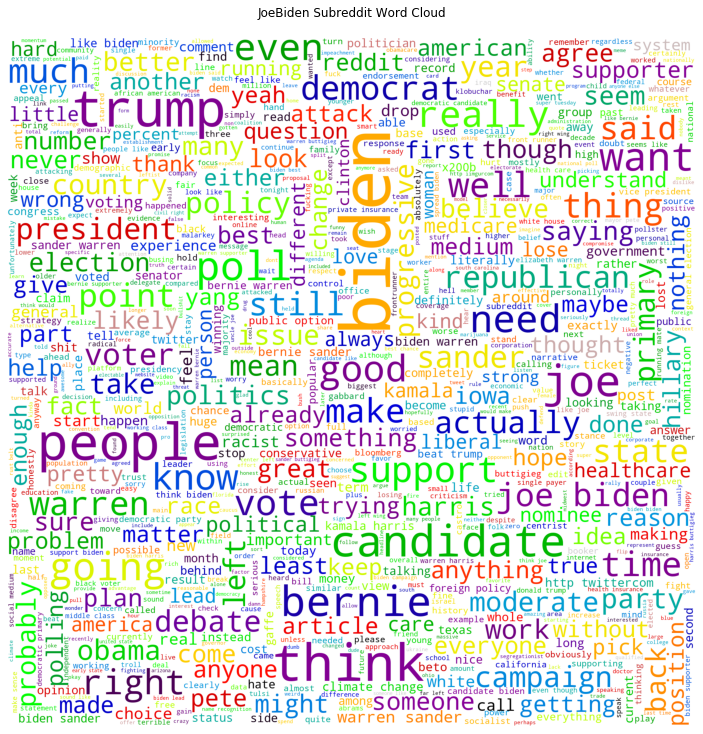

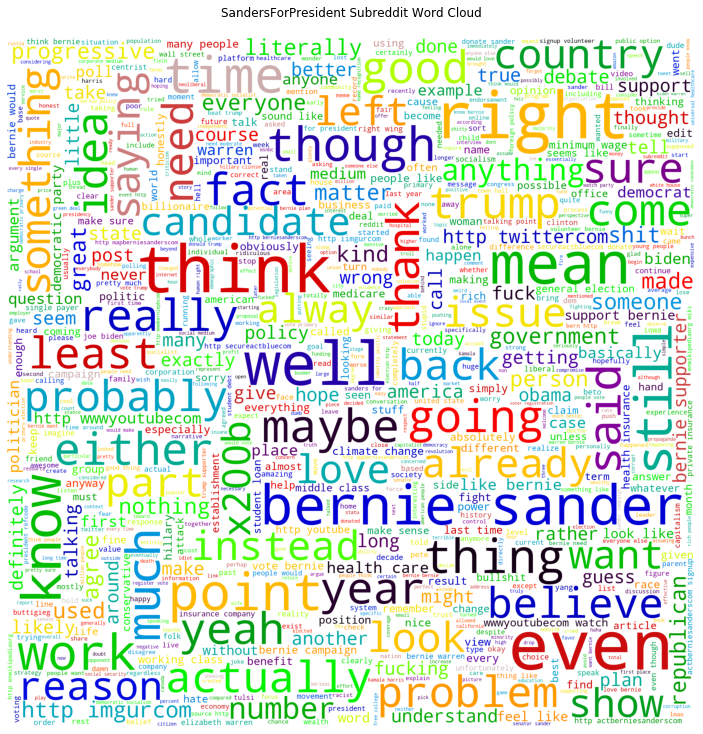

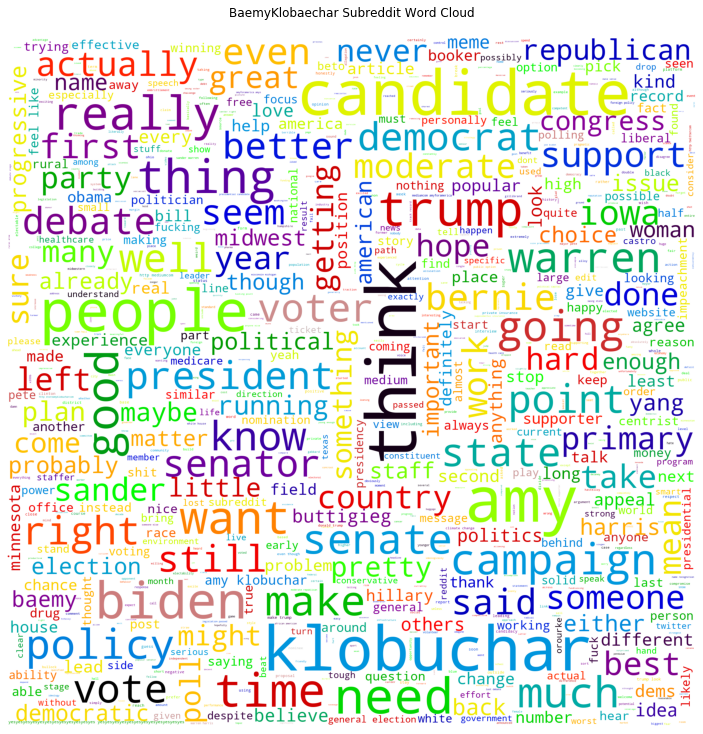

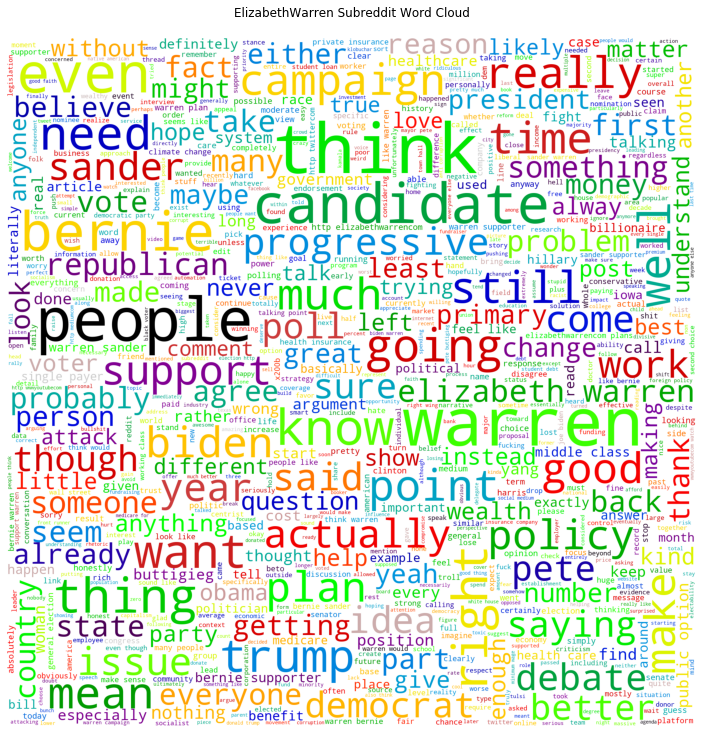

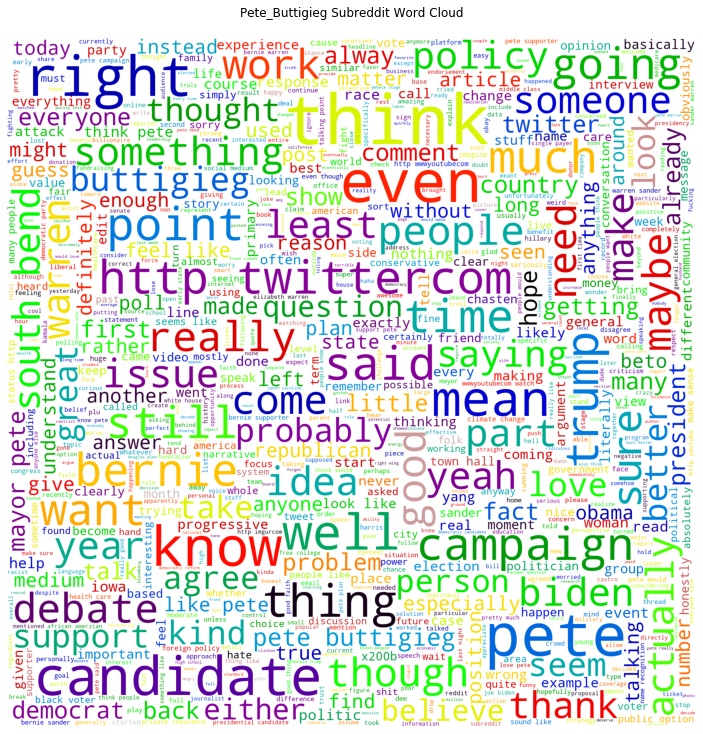

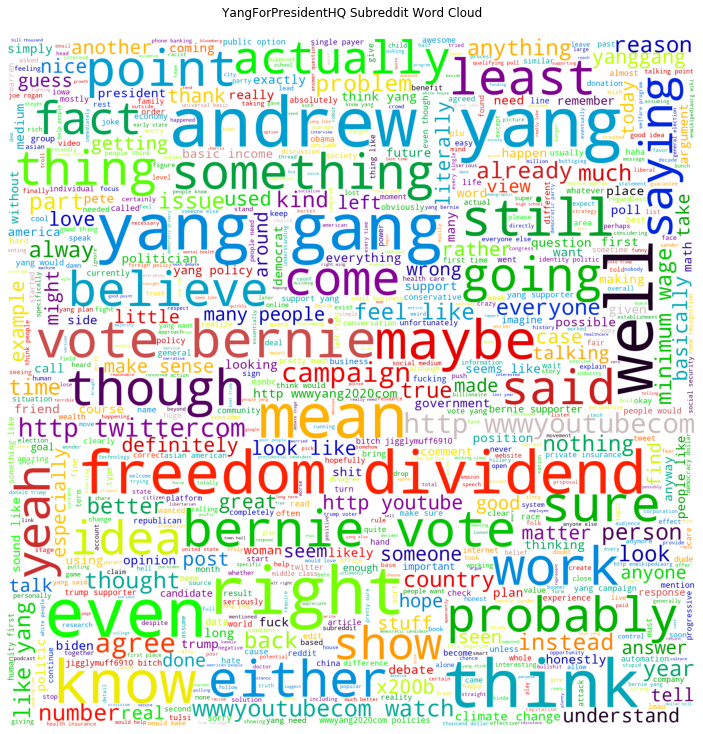

In [70]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

for candidate in left_candidates:
    text = comments.where(comments["subreddit"] == candidate).select("clean_body").rdd.flatMap(lambda x: x).collect()
    print(text[:10])
    word_cloud = WordCloud(width=2000, height=2000, max_font_size=200, background_color="white", max_words=800,
                        colormap="nipy_spectral", stopwords=STOPWORDS).generate(' '.join(text))
    plt.figure(figsize=(10, 10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.title("{} Subreddit Word Cloud\n".format(candidate))
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig("visualizations/wordclouds/{}_subreddit_word_cloud".format(candidate))